## 2019 2nd ML month with KaKR

https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/overview

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

### 데이터 준비

In [3]:
data = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
x_train = data.copy()
y_train = x_train.pop("price")

In [4]:
x_train.shape, test.shape, y_train.shape

((15035, 20), (6468, 20), (15035,))

In [5]:
x_train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


날짜 데이터를 연도,월이 이어져있는 6자리 숫자를 연도를 소수표현으로 변환   
date = 연도 + 월 * 1/12

In [6]:
x_train["year"] = x_train["date"].apply(lambda x: str(x[:4])).astype(int)
test["year"] = test["date"].apply(lambda x: str(x[:4])).astype(int)
x_train["month"] = x_train["date"].apply(lambda x: str(x[4:6])).astype(int)
test["month"] = test["date"].apply(lambda x: str(x[4:6])).astype(int)

x_train["date"] = x_train["year"] + (x_train["month"] * 1 / 12)
test["date"] = test["year"] + (test["month"] * 1 / 12)

# id와 임시로 만든 year, month 삭제
x_train.drop(["id", "year", "month"], axis=1, inplace=True)
test.drop(["id", "year", "month"], axis=1, inplace=True)

In [7]:
x_train["date"].head()

0    2014.833333
1    2015.166667
2    2015.166667
3    2014.500000
4    2015.083333
Name: date, dtype: float64

분포 조정

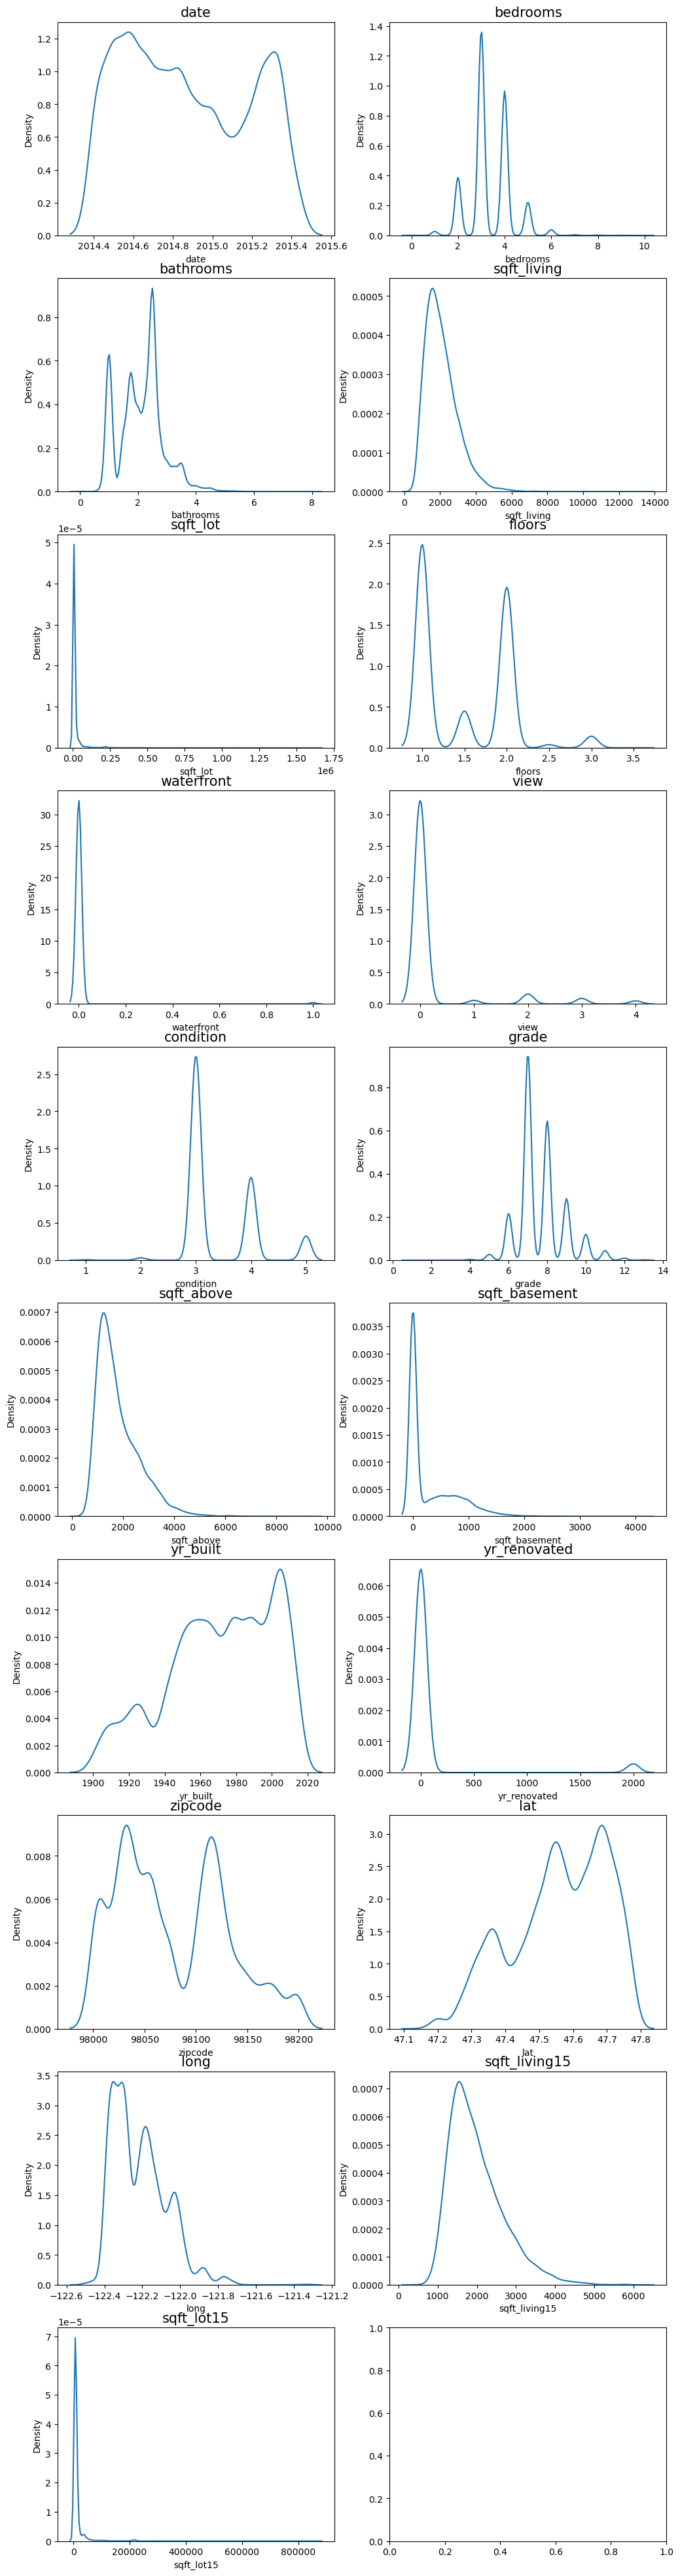

In [8]:
fig, ax = plt.subplots(10, 2, figsize=(12, 50))

count = 0
columns = x_train.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=x_train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

In [9]:
skew_columns = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "sqft_lot",
    "sqft_above",
    "sqft_basement",
    "sqft_lot15",
    "sqft_living15",
]


for c in skew_columns:
    x_train[c] = np.log1p(x_train[c].values)
    test[c] = np.log1p(test[c].values)

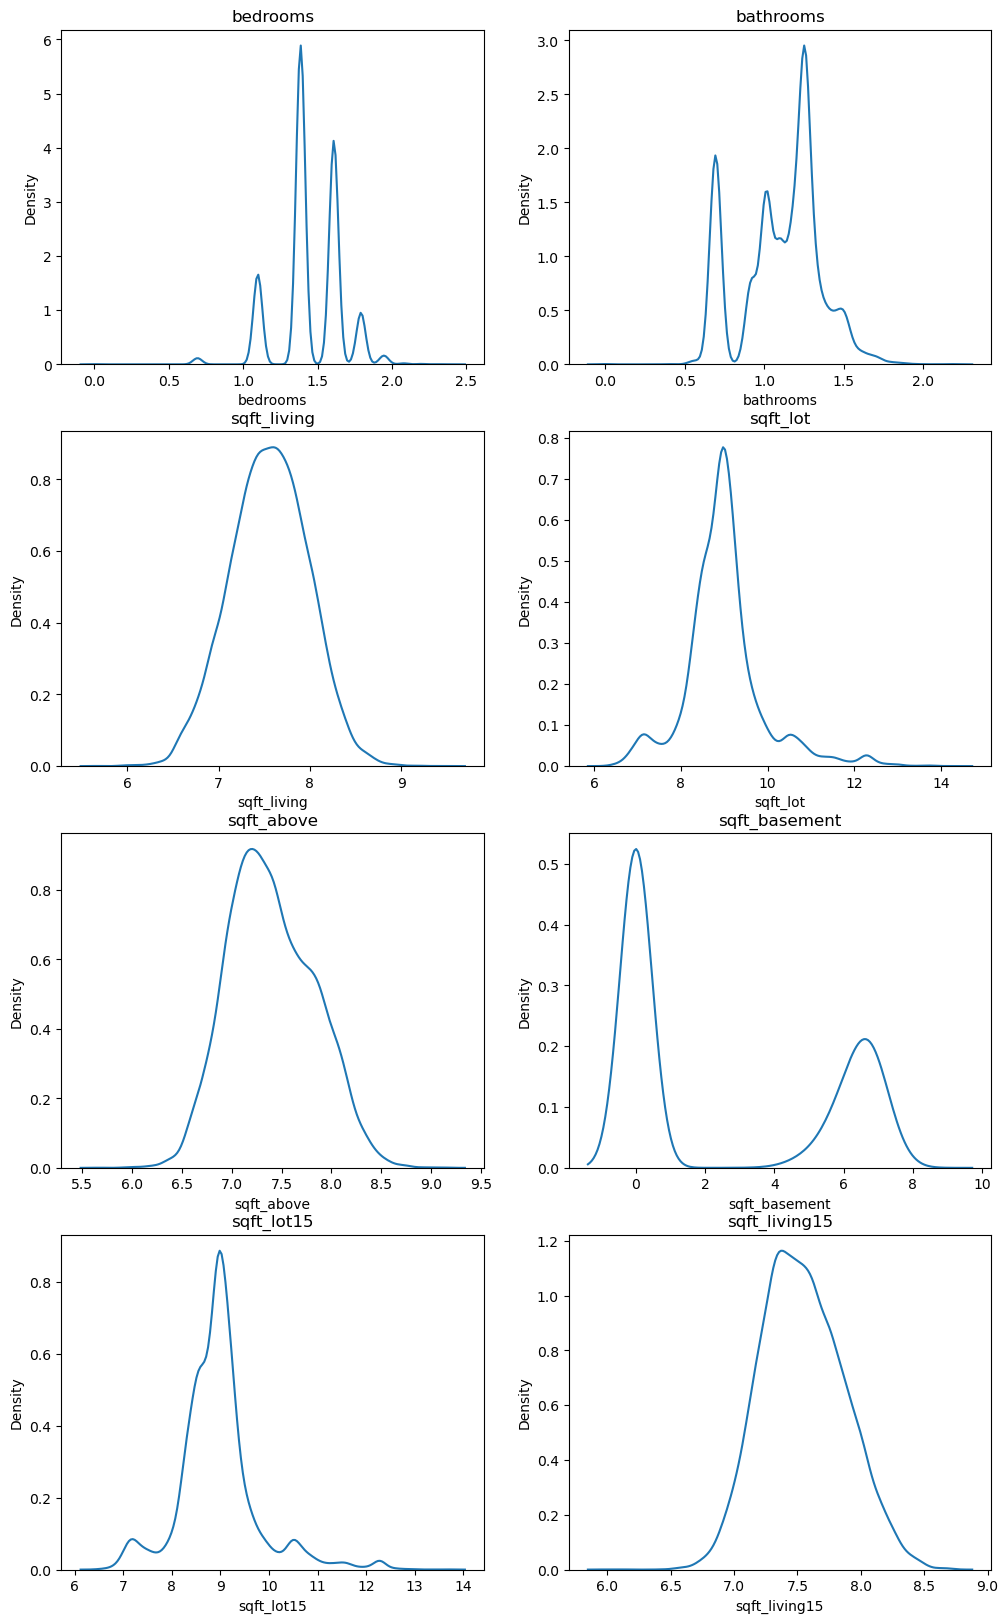

In [10]:
row = int(len(skew_columns) / 2)
col = 2
fig, ax = plt.subplots(row, col, figsize=(12, 20))
idx = 0
for r in range(row):
    for c in range(col):
        sns.kdeplot(data=x_train[skew_columns[idx]], ax=ax[r][c])
        ax[r][c].set_title(skew_columns[idx])
        idx += 1

타겟 역시 로그변환을 해주었다

<Axes: xlabel='price', ylabel='Density'>

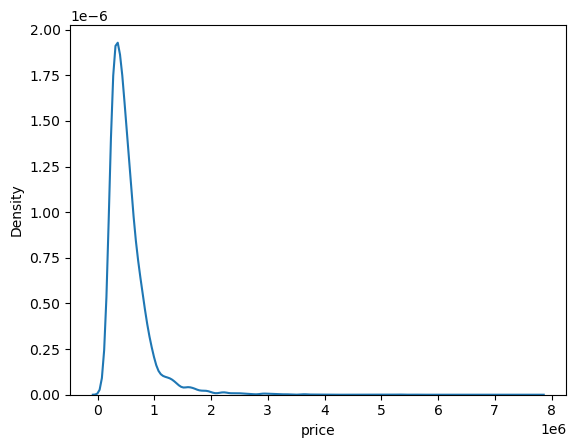

In [11]:
sns.kdeplot(y_train)

<Axes: xlabel='price', ylabel='Density'>

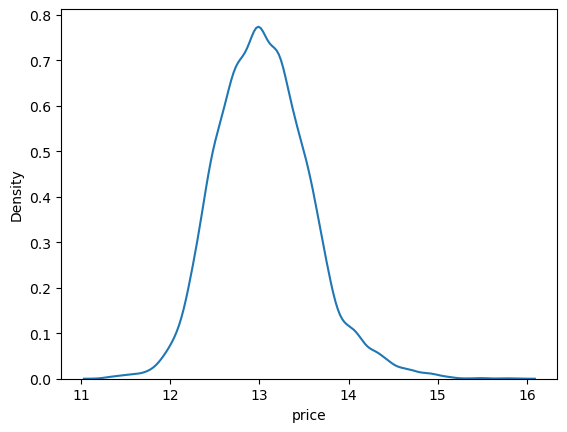

In [12]:
y_train = np.log1p(y_train)
sns.kdeplot(y_train)

정규화

In [13]:
scalar = MinMaxScaler()
x_train = pd.DataFrame(scalar.fit_transform(x_train), columns=x_train.columns)
test = pd.DataFrame(scalar.transform(test), columns=x_train.columns)

In [14]:
x_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0.416667,0.578130,0.315465,0.364775,0.295712,0.0,0.0,0.0,0.5,0.500000,0.402954,0.0,0.478261,0.0,0.893939,0.571498,0.217608,0.441078,0.300037
1,0.750000,0.458157,0.315465,0.253731,0.366525,0.0,0.0,0.0,0.5,0.416667,0.280287,0.0,0.286957,0.0,0.136364,0.936143,0.237542,0.699074,0.349422
2,0.750000,0.578130,0.500000,0.456706,0.340082,0.0,0.0,0.0,0.5,0.583333,0.504506,0.0,0.756522,0.0,0.368687,0.741354,0.393688,0.548613,0.339440
3,0.083333,0.578130,0.536429,0.462072,0.319036,0.4,0.0,0.0,0.5,0.500000,0.510434,0.0,0.826087,0.0,0.010101,0.247386,0.159468,0.627985,0.326161
4,0.666667,0.578130,0.417022,0.336873,0.362888,0.0,0.0,0.0,0.5,0.500000,0.372131,0.0,0.547826,0.0,0.994949,0.407914,0.169435,0.516906,0.375275


추가 변수 생성

면적에 대한 정확한 이해를 하지 못하였지만, 모든 값을 더한 총 면적을 추가   
일단 별도의 공간에 대한 면적으로 보임 

In [15]:
x_train[["sqft_living", "sqft_lot", "sqft_above", "sqft_basement"]]

,sqft_living,sqft_lot,sqft_above,sqft_basement
0,0.364775,0.295712,0.402954,0.000000
1,0.253731,0.366525,0.280287,0.000000
2,0.456706,0.340082,0.504506,0.000000
3,0.462072,0.319036,0.510434,0.000000
4,0.336873,0.362888,0.372131,0.000000
...,...,...,...,...
15030,0.562240,0.303641,0.621086,0.000000
15031,0.648498,0.325779,0.630072,0.818438
15032,0.432366,0.096261,0.477619,0.000000
15033,0.539591,0.299239,0.596066,0.000000


In [16]:
x_train["sqft_total"] = (
    x_train["sqft_living"]
    + x_train["sqft_lot"]
    + x_train["sqft_above"]
    + x_train["sqft_basement"]
)
test["sqft_total"] = (
    test["sqft_living"] + test["sqft_lot"] + test["sqft_above"] + test["sqft_basement"]
)
x_train["sqft_total15"] = (
    x_train["sqft_living15"]
    + x_train["sqft_lot15"]
    + x_train["sqft_above"]
    + x_train["sqft_basement"]
)
test["sqft_total15"] = (
    test["sqft_living15"]
    + test["sqft_lot15"]
    + test["sqft_above"]
    + test["sqft_basement"]
)

총 방의 개수 추가

In [17]:
x_train["rooms"] = x_train["bedrooms"] + x_train["bathrooms"]
test["rooms"] = test["bedrooms"] + test["bathrooms"]

재건축 여부 추가

In [18]:
x_train["renovated"] = x_train["yr_renovated"].apply(lambda x: 0 if x == 0 else 1)
test["renovated"] = test["yr_renovated"].apply(lambda x: 0 if x == 0 else 1)

### 모델 비교

In [19]:
random_state = 42

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [144]:
def get_scores(models, train, y):
    df = {}
    x_train, x_test, y_train, y_test = train_test_split(
        train, y, train_size=0.8, random_state=42
    )

    for model in models:
        model_name = model.__class__.__name__

        model.fit(x_train, y_train)
        pred = model.predict(x_test)

        df[model_name] = root_mean_squared_error(np.expm1(y_test), np.expm1(pred))

        score_df = pd.DataFrame(df, index=["RMSE"]).T.sort_values(
            "RMSE", ascending=False
        )

    return score_df

In [147]:
get_scores(models, x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2894
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 23
[LightGBM] [Info] Start training from score 13.047364


,RMSE
RandomForestRegressor,141708.641052
GradientBoostingRegressor,132427.594473
XGBRegressor,128499.579527
LGBMRegressor,120425.000967


### 파인튜닝

In [188]:
param_grid = {
    "learning_rate": [0.1, 0.01, 0.001],
    "max_depth": [5, 10, 15],
    "n_estimators": [50, 100, 150],
}

In [182]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",
        cv=5,
        verbose=verbose,
        n_jobs=n_jobs,
    )

    grid_model.fit(train, y)

    params = grid_model.cv_results_["params"]
    score = grid_model.cv_results_["mean_test_score"]

    results = pd.DataFrame(params)
    results["score"] = score

    results["RMSLE"] = np.sqrt(-1 * results["score"])
    results = results.sort_values("RMSLE")

    return results

In [190]:
model = LGBMRegressor(random_state=random_state)

In [154]:
my_GridSearch(model, x_train, y_train, param_grid)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x000001C54A260580>
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: 0x000001C54A260C40>
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2941
[LightGBM] [Info] Number of data points in the train set: 15035, number of used fe

,learning_rate,max_depth,n_estimators,score,RMSLE
5,0.100,10,150,-0.026789,0.163674
8,0.100,15,150,-0.026810,0.163739
7,0.100,15,100,-0.027281,0.165170
4,0.100,10,100,-0.027315,0.165273
2,0.100,5,150,-0.027754,0.166596
1,0.100,5,100,-0.028651,0.169266
3,0.100,10,50,-0.029421,0.171525
6,0.100,15,50,-0.029421,0.171526
0,0.100,5,50,-0.031541,0.177599
17,0.010,15,150,-0.055687,0.235981


lr이 제일 높은게 좋았기에 더 높여야하는지,iteration을 늘려야할 지 파악

In [192]:
param_grid = {
    "learning_rate": [0.3, 0.1, 0.05],
    "num_iterations": [100, 300, 500],
    "max_depth": [10],
    "n_estimators": [200, 300],
}
my_GridSearch(model, x_train, y_train, param_grid)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\zzoon\anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2941
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 23
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
17,0.05,10,300,500,-0.026020,0.161308
14,0.05,10,200,500,-0.026020,0.161308
13,0.05,10,200,300,-0.026402,0.162487
16,0.05,10,300,300,-0.026402,0.162487
10,0.10,10,300,300,-0.026452,0.162642
7,0.10,10,200,300,-0.026452,0.162642
11,0.10,10,300,500,-0.026493,0.162766
8,0.10,10,200,500,-0.026493,0.162766
9,0.10,10,300,100,-0.027315,0.165273
6,0.10,10,200,100,-0.027315,0.165273


iteration을 늘리며 탐색

In [193]:
param_grid = {
    "learning_rate": [0.05, 0.001],
    "num_iterations": [500, 1000, 2000],
    "max_depth": [10],
    "n_estimators": [200, 300, 400],
}
my_GridSearch(model, x_train, y_train, param_grid)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\zzoon\anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2941
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 23
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
0,0.050,10,200,500,-0.026020,0.161308
3,0.050,10,300,500,-0.026020,0.161308
6,0.050,10,400,500,-0.026020,0.161308
1,0.050,10,200,1000,-0.026108,0.161581
7,0.050,10,400,1000,-0.026108,0.161581
4,0.050,10,300,1000,-0.026108,0.161581
8,0.050,10,400,2000,-0.026461,0.162668
2,0.050,10,200,2000,-0.026461,0.162668
5,0.050,10,300,2000,-0.026461,0.162668
11,0.001,10,200,2000,-0.043838,0.209376


stacking cv

성능이 좋아지지 않아 stacking 방법을 사용  
RMSLE가 0.161308인 값으로 제출했는데 118185.91037가 나옴 


In [20]:
from mlxtend.regressor import StackingCVRegressor

In [30]:
lgbm = LGBMRegressor(
    num_leaves=64,
    learning_rate=0.05,
    # max_depth=10,
    n_estimators=200,
    random_state=random_state,
)


xgb = XGBRegressor(
    learning_rate=0.05,
    # max_depth=10,
    n_estimators=200,
    random_state=random_state,
)


rf = RandomForestRegressor(
    # max_depth=10,
    n_estimators=200,
    random_state=random_state,

)


stack = StackingCVRegressor(
    regressors=(lgbm, xgb, rf),
    cv=5,
    meta_regressor=lgbm,
    use_features_in_secondary=True,
)

In [31]:
model = stack.fit(np.array(x_train), np.array(y_train))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2927
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 23
[LightGBM] [Info] Start training from score 13.047924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 23
[LightGBM] [Info] Start training from score 13.046430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2888
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 23
[LightGBM] [Info] Start t

In [265]:
pred = model.predict(np.array(x_train))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


train세트에 대한 rmsle

In [266]:
rmsle = np.sqrt(mean_squared_error(y_train, pred))
rmsle

0.09916909683502531

### 제출

캐글에서 스코어 106861.47507달성  
![score](score.png)

In [267]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    pred = model.predict(test)
    pred = np.expm1(pred)
    submission = pd.read_csv("data/sample_submission.csv")
    submission["price"] = pred
    submission.to_csv(
        f"data/sample_submission_{model_name}_RMSLE_{rmsle}.csv", index=False
    )

In [268]:
save_submission(model, x_train, y_train, test, "stack", rmsle)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2926
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 23
[LightGBM] [Info] Start training from score 13.044581
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightG

c:\Users\zzoon\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


### 회고


stacking이란 방법의 이론적 지식을 몰라서 안쓰고 싶었는데, 성능이 좋아지게할 방법을 찾지 못하여 결국 쓰게되었다.  
성능이 유의미 하게 변하는 것을 보니 유용한 기법이라고 생각하였고 이 stacking 기법에 대하여 추가적으로 공부해야할 것 같다. 

또한 lgbm에서 경고문구인 `[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).`에 대해서도 알아봐야할 거 같다. 분명 max_depth를 10으로 설정해서 $2^{10}$이 31보다 큼에도 왜 이런 오류가 나는지 모르겠다.
